In [1]:
import tensorflow as tf
import numpy as np
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
import cv2
def resize_batch(imgs):
    # A function to resize a batch of MNIST images to (32, 32)
    # Args:
    #   imgs: a numpy array of size [batch_size, 28 X 28].
    # Returns:
    #   a numpy array of size [batch_size, 32, 32].
    resized_imgs = np.zeros((imgs.shape[0], 32, 32))
    for i in range(imgs.shape[0]):
        resized_imgs[i, ...] = cv2.resize(imgs[i], dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
    return resized_imgs
x_train = resize_batch(x_train)
x_test = resize_batch(x_test)

//anaconda/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [41]:
import copy
class Batcher():
    def __init__(self,x_train,mini_batch_size):
        self.epoch = 1
        self.mini_batch_size = mini_batch_size
        self.nbatches = int(len(x_train)/mini_batch_size)
        if len(x_train)%self.nbatches==0:
            self.perfect_sample = 1
        else:
            self.perfect_sample = 0
        self.samples = copy.deepcopy(x_train)
        np.random.shuffle(self.samples)
        self.batch=0
    def get_mini_batch(self):
        if self.batch < (self.nbatches-self.perfect_sample):
            samples= self.samples[self.batch*self.mini_batch_size:((self.batch+1)*self.mini_batch_size)]
            last_batch = False
        else:
            samples = self.samples[self.batch*self.mini_batch_size:]
            np.random.shuffle(self.samples)
            self.epoch += 1
            self.batch = 0
            last_batch = True
        self.batch += 1
        return samples,last_batch
    

In [51]:
tf.reset_default_graph() # THIS IS NECESSARY BEFORE MAKING NEW SESSION TO STOP IT ERRORING!!

if not(tf.get_default_session() is None):
    tf.get_default_session().close()

sess = tf.InteractiveSession()

class VariationalAutoEncoder():
    def __init__(self,latent_dim,pixel_dims = 32):
        self.latent_dim = latent_dim
        self.pixel_dims = pixel_dims
        self.input = tf.placeholder(tf.float32,[None,pixel_dims,pixel_dims],name='input')
        scaled_input = self.input / 255
        self.total_pixels = pixel_dims**2
        
        self.encoded_mean,self.encoded_log_sigma = self.encoder(scaled_input)
        noisy_encoded = self.add_latent(self.encoded_mean,self.encoded_log_sigma)
        self.input_decoded = self.decoder(noisy_encoded)
        self.output_image = 255*self.input_decoded[0]
          
        self.latent_in = tf.placeholder(tf.float32,[None,latent_dim],name='latent_in')
        self.latent_image = 255*self.decoder(self.latent_in)[0]
        
        self.xent_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=scaled_input,logits=self.input_decoded[1]),axis=[1,2])
        self.kl_loss = -0.5*tf.reduce_sum((1 + self.encoded_log_sigma - tf.square(self.encoded_mean) - tf.exp(self.encoded_log_sigma)),axis=1)
        self.loss = tf.reduce_mean(self.kl_loss+self.xent_loss)/self.total_pixels
        self.train_op = tf.train.AdamOptimizer(learning_rate = 1e-3).minimize(self.loss)
        
        tf.global_variables_initializer().run() 
        
    def encoder(self,x):
        with tf.variable_scope('encoder',reuse=tf.AUTO_REUSE):
            x = tf.contrib.layers.flatten(x)
            x = tf.contrib.slim.fully_connected(x,256,activation_fn=tf.nn.relu,scope='ec1')
            x = tf.contrib.slim.fully_connected(x,256,activation_fn=tf.nn.relu,scope='ec2')
        mean,log_sigma = tf.split(tf.contrib.slim.fully_connected(x,self.latent_dim*2,activation_fn=None,scope='ec3'),2,axis=1)
        return mean,log_sigma
    def add_latent(self,mean,log_sigma):
        z = tf.random_normal([self.latent_dim])
        return mean #+ tf.exp(log_sigma)*z
    def decoder(self,x):
        with tf.variable_scope('decoder',reuse=tf.AUTO_REUSE):
            x = tf.contrib.slim.fully_connected(x,256,activation_fn=tf.nn.relu,scope='dc1')
            x = tf.contrib.slim.fully_connected(x,256,activation_fn=tf.nn.relu,scope='dc2')
            x =tf.contrib.slim.fully_connected(x,self.total_pixels,activation_fn=None,scope='dc3')
        logits = tf.reshape(x,[-1,self.pixel_dims,self.pixel_dims])
        sig_x = tf.sigmoid(logits)
        return sig_x,logits

m = VariationalAutoEncoder(10)

mini_batch_size = 128

b = Batcher(x_train,mini_batch_size)
max_epochs = 20
print("Batches per epoch %d" %b.nbatches)
while b.epoch <= max_epochs:
    batch, new_epoch = b.get_mini_batch()
    _,loss = sess.run([m.train_op,m.loss],feed_dict = {m.input : batch})
    if b.batch%(int(b.nbatches/3))==0:
        print("Train loss is %f at batch %d" % (loss,b.batch))
    if new_epoch:
        _,test_loss = sess.run([m.train_op,m.loss],feed_dict = {m.input : x_test})
        print("Test loss is %f at epoch %d" % (test_loss,b.epoch-1))
        

Batches per epoch 468
Train loss is 0.197284 at batch 156
Train loss is 0.162282 at batch 312
Train loss is 0.143635 at batch 468
Test loss is 0.145857 at epoch 1
Train loss is 0.140725 at batch 156
Train loss is 0.135765 at batch 312
Train loss is 0.132653 at batch 468
Test loss is 0.134060 at epoch 2
Train loss is 0.128076 at batch 156
Train loss is 0.134296 at batch 312
Train loss is 0.130198 at batch 468
Test loss is 0.128720 at epoch 3
Train loss is 0.124969 at batch 156
Train loss is 0.128880 at batch 312
Train loss is 0.126014 at batch 468
Test loss is 0.125319 at epoch 4
Train loss is 0.121141 at batch 156
Train loss is 0.125095 at batch 312
Train loss is 0.119536 at batch 468
Test loss is 0.123092 at epoch 5
Train loss is 0.117352 at batch 156
Train loss is 0.120285 at batch 312
Train loss is 0.117819 at batch 468
Test loss is 0.121246 at epoch 6
Train loss is 0.121173 at batch 156
Train loss is 0.126455 at batch 312
Train loss is 0.114781 at batch 468
Test loss is 0.119775 at

KeyboardInterrupt: 

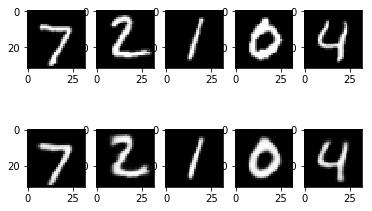

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
nim=5
in_ims = x_test[:nim]
ims = m.output_image.eval(feed_dict = {m.input : in_ims})

for n,(im,in_im) in enumerate(zip(ims,in_ims)):
    plt.subplot(2,nim,1 + n)
    plt.imshow(in_im,cmap='gray')
    plt.subplot(2,nim,nim + n + 1)
    plt.imshow(im,cmap='gray')

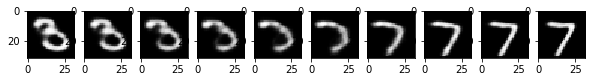

In [53]:
threes = [x for i,x in enumerate(x_test) if y_test[i] == 3]
three_val = m.encoded_mean.eval(feed_dict = {m.input : threes})[0]

sevens = [x for i,x in enumerate(x_test) if y_test[i] == 7]
seven_val = m.encoded_mean.eval(feed_dict = {m.input : sevens})[0]

plt.figure(figsize=(10, 3))

latent_var_range = np.array([np.linspace(t,s,10) for t,s in zip(three_val,seven_val)]).T
for x,pos in enumerate(latent_var_range):
    im = m.latent_image.eval(feed_dict = {m.latent_in : [pos]})[0]
    plt.subplot(1,10,x+1)
    plt.imshow(im,cmap='gray')

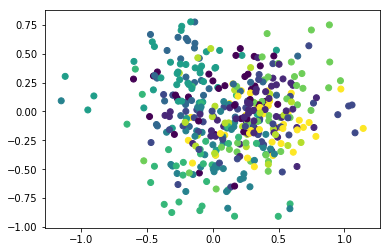

In [54]:
means = m.encoded_mean.eval(feed_dict = {m.input : x_test[:400]})
tag = np.array(y_test[:400]).astype(int)

# make the scatter
scat = plt.scatter(means[:,0],means[:,1],c=tag)

plt.show()

In [55]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
X_tsne = TSNE(learning_rate=100).fit_transform(means)
X_pca = PCA().fit_transform(means)


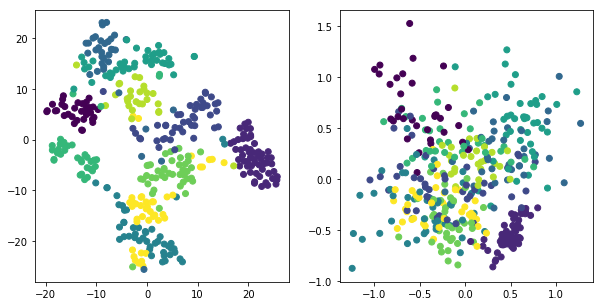

In [56]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c=tag)
plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=tag)

In [ ]:
tf.reset_default_graph() # THIS IS NECESSARY BEFORE MAKING NEW SESSION TO STOP IT ERRORING!!

if not(tf.get_default_session() is None):
    tf.get_default_session().close()

sess = tf.InteractiveSession()

class ConvVariationalAutoEncoder(VariationalAutoEncoder):
     def encoder(self,x):
        with tf.variable_scope('encoder',reuse=tf.AUTO_REUSE):
            x = tf.contrib.slim.conv2d(tf.expand_dims(x,3),32,5,stride = 2,padding = 'SAME',activation_fn=tf.nn.relu)
            x = tf.contrib.slim.conv2d(x,16,5,stride = 2,padding = 'SAME',activation_fn=tf.nn.relu)
            x = tf.contrib.slim.conv2d(x,8,5,stride = 4,padding = 'SAME',activation_fn=tf.nn.relu)
            self.dim_c = x.shape[1:]
            x = tf.contrib.layers.flatten(x)
            x = tf.contrib.slim.fully_connected(x,self.latent_dim*2,activation_fn=None)
        mean,log_sigma = tf.split(x,2,axis=1)
        return mean,log_sigma
    
     def decoder(self,x):
        with tf.variable_scope('decoder',reuse=tf.AUTO_REUSE):
            x = tf.contrib.slim.fully_connected(x,int(np.prod(self.dim_c)),activation_fn=None)
            x =tf.reshape(x,[-1]+list(self.dim_c))
            x = tf.contrib.slim.conv2d_transpose(x,32,5,stride = 4,padding = 'SAME',activation_fn=tf.nn.relu)
            x = tf.contrib.slim.conv2d_transpose(x,16,5,stride = 2,padding = 'SAME',activation_fn=tf.nn.relu)
            x = tf.contrib.slim.conv2d_transpose(x,1,5,stride = 2,padding = 'SAME',activation_fn=None)
        logits = tf.squeeze(x,axis=3)
        sig_x = tf.sigmoid(logits)
        return sig_x,logits

m = ConvVariationalAutoEncoder(5)
        
mini_batch_size = 128

b = Batcher(x_train,mini_batch_size)
max_epochs = 10
print("Batches per epoch %d" %b.nbatches)
while b.epoch <= max_epochs:
    batch, new_epoch = b.get_mini_batch()
    _,loss = sess.run([m.train_op,m.loss],feed_dict = {m.input : batch})
    if b.batch%(int(b.nbatches/3))==0:
        print("Train loss is %f at batch %d" % (loss,b.batch))
    if new_epoch:
        _,test_loss = sess.run([m.train_op,m.loss],feed_dict = {m.input : x_test})
        print("Test loss is %f at epoch %d" % (test_loss,b.epoch-1))
        

Tensor("split:0", shape=(?, 5), dtype=float32)
Tensor("decoder/fully_connected/BiasAdd:0", shape=(?, 32), dtype=float32)
Tensor("decoder/Reshape:0", shape=(?, 2, 2, 8), dtype=float32)
Tensor("latent_in:0", shape=(?, 5), dtype=float32)
Tensor("decoder_1/fully_connected/BiasAdd:0", shape=(?, 32), dtype=float32)
Tensor("decoder_1/Reshape:0", shape=(?, 2, 2, 8), dtype=float32)
Batches per epoch 468


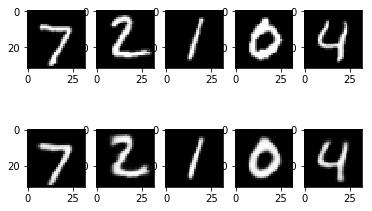

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
nim=5
in_ims = x_test[:nim]
ims = m.output_image.eval(feed_dict = {m.input : in_ims})

for n,(im,in_im) in enumerate(zip(ims,in_ims)):
    plt.subplot(2,nim,1 + n)
    plt.imshow(in_im,cmap='gray')
    plt.subplot(2,nim,nim + n + 1)
    plt.imshow(im,cmap='gray')

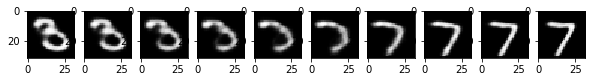

In [53]:
threes = [x for i,x in enumerate(x_test) if y_test[i] == 3]
three_val = m.encoded_mean.eval(feed_dict = {m.input : threes})[0]

sevens = [x for i,x in enumerate(x_test) if y_test[i] == 7]
seven_val = m.encoded_mean.eval(feed_dict = {m.input : sevens})[0]

plt.figure(figsize=(10, 3))

latent_var_range = np.array([np.linspace(t,s,10) for t,s in zip(three_val,seven_val)]).T
for x,pos in enumerate(latent_var_range):
    im = m.latent_image.eval(feed_dict = {m.latent_in : [pos]})[0]
    plt.subplot(1,10,x+1)
    plt.imshow(im,cmap='gray')

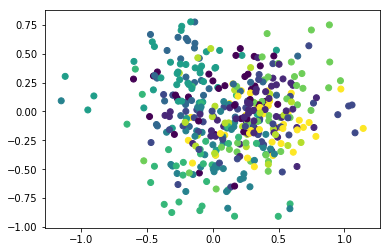

In [54]:
means = m.encoded_mean.eval(feed_dict = {m.input : x_test[:400]})
tag = np.array(y_test[:400]).astype(int)

# make the scatter
scat = plt.scatter(means[:,0],means[:,1],c=tag)

plt.show()

In [55]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
X_tsne = TSNE(learning_rate=100).fit_transform(means)
X_pca = PCA().fit_transform(means)


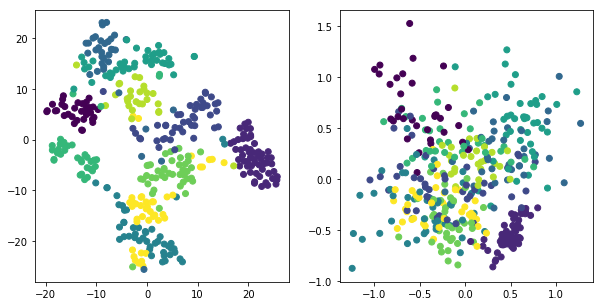

In [56]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c=tag)
plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=tag)